In [186]:
! rm -r -f amalearn

In [187]:
! unzip amalearn-0.1.zip

Archive:  amalearn-0.1.zip
   creating: amalearn/
   creating: amalearn/.git/
  inflating: amalearn/.git/description  
   creating: amalearn/.git/hooks/
  inflating: amalearn/.git/hooks/applypatch-msg.sample  
  inflating: amalearn/.git/hooks/commit-msg.sample  
  inflating: amalearn/.git/hooks/fsmonitor-watchman.sample  
  inflating: amalearn/.git/hooks/post-update.sample  
  inflating: amalearn/.git/hooks/pre-applypatch.sample  
  inflating: amalearn/.git/hooks/pre-commit.sample  
  inflating: amalearn/.git/hooks/pre-merge-commit.sample  
  inflating: amalearn/.git/hooks/pre-push.sample  
  inflating: amalearn/.git/hooks/pre-rebase.sample  
  inflating: amalearn/.git/hooks/pre-receive.sample  
  inflating: amalearn/.git/hooks/prepare-commit-msg.sample  
  inflating: amalearn/.git/hooks/update.sample  
   creating: amalearn/.git/info/
  inflating: amalearn/.git/info/exclude  
   creating: amalearn/.git/refs/
   creating: amalearn/.git/refs/heads/
  inflating: amalearn/.git/refs/heads/

In [188]:
! pip install -e ./amalearn

Obtaining file:///content/amalearn
  Found existing installation: amalearn 0.1
    Can't uninstall 'amalearn'. No files were found to uninstall.
  Running setup.py develop for amalearn


In [189]:
from amalearn.reward import RewardBase
import numpy as np

class CompanyShare(RewardBase):
    def __init__(self, base, p, id):
        super(CompanyShare, self).__init__()
        self.base = base
        self.base_cp = base
        self.id = id
        self.p = p

    def reset(self):
        self.base = self.base_cp
        # print(self.base)

    def update_normal(self):
        act = np.random.choice(3, 1, p=self.p)
        if act == 0:
          self.base += 5
        elif act == 1:
          self.base -= 5
        else:
          self.base = self.base

    def update_min(self):
        act = np.random.choice(2, 1, p=[0.75, 0.25])
        if act == 0:
          self.base += 5
        else:
          self.base = self.base

    def update_max(self):
        act = np.random.choice(2, 1, p=[0.75, 0.25])
        if act == 0:
          self.base -= 5
        else:
          self.base = self.base

    def update(self):
        if self.base == 5:
          self.update_min()
        elif self.base == 50:
          self.update_max()
        else:
          self.update_normal()

    def get_reward(self):
        return self.base

In [190]:
from amalearn.reward import RewardBase
import numpy as np

class ComponiesShare(RewardBase):
    def __init__(self, share_list, id):
        super(ComponiesShare, self).__init__()
        self.share_list = share_list
        self.id = id

    def get_id(self):
        return self.id

    def get_len(self):
        return len(self.share_list)

    def get_reward(self):
        res = 0
        for share in self.share_list:
          res += share.get_reward()
        if res == 0:
          res = -1
        return res

In [191]:
class State:
    def __init__(self, cash, componies):
        self.st = [cash]
        self.st.extend([i.get_reward() for i in componies])

    def get_value(self):
        return self.st



In [192]:
import gym
import copy
from amalearn.environment import EnvironmentBase

class MDPEnvironment(EnvironmentBase):
    def __init__(self, componies, acts, id, container=None):
        state_space = gym.spaces.Discrete(21000)
        action_space = gym.spaces.Discrete(len(acts))

        super(MDPEnvironment, self).__init__(action_space, state_space, id, container)
        self.acts = acts
        self.componies = componies
        # self.acts_cp = copy.deepcopy(acts)
        # self.componies_cp = copy.deepcopy(componies)
        self.id = id
        self.reward = 0
        self.state_s = State(4,componies)
        self.state_e = State(4,componies)
        self.last_act = ''
        self.eps = {'s':[], 'a':[], 'r':[], 'sp':[]}

    def get_componies(self):
        return self.componies

    def calculate_reward(self, action):
        before = self.acts[action].get_reward()
        self.last_act = self.acts[action].get_id()
        for compony in self.componies:
          compony.update()
        after = self.acts[action].get_reward()
        self.state_e = State(self.state_s.get_value()[0] + (after-before)/float(5), self.componies)
        if self.state_s.get_value()[0]*5 < before:
          self.reward = -1000001
          self.reward = (-1*float('inf'))
          print(self.state_s.get_value(), action)
          self.state_e = State(self.state_s.get_value()[0], self.componies)
        elif self.state_s.get_value()[0]*5 >= before and before == -1:
          self.reward = -1000000
          self.state_e = State(self.state_s.get_value()[0], self.componies)
        elif self.state_s.get_value()[0]*5 >= before and before != -1 and self.state_e.get_value()[0] <= 0:
          self.reward = -20000001
          self.state_e = State(0, self.componies)
        elif self.state_s.get_value()[0]*5 >= before and before != -1 and self.state_e.get_value()[0] >= 20:
          self.reward = 20000000-1
          self.state_e = State(20, self.componies)
        elif self.state_s.get_value()[0]*5 >= before and before != -1 and self.state_e.get_value()[0] < 20 and self.state_e.get_value()[0] > 0:
          self.reward = 50000 * (self.state_e.get_value()[0]-self.state_s.get_value()[0])
          if self.state_e.get_value()[0] < self.state_s.get_value()[0]:
            self.reward = -50000 * (self.state_s.get_value()[0]-self.state_e.get_value()[0])
          elif self.state_e.get_value()[0] == self.state_s.get_value()[0]:
            self.reward = -50000 * self.acts[action].get_len()

        if self.reward != float('-inf'):
          self.eps['s'].append(self.state_s)
          self.eps['a'].append(action)
          self.eps['r'].append(self.reward)
          self.eps['sp'].append(self.state_e)
        return self.reward

    def terminated(self):
        return self.state_e.get_value()[0] == 20 or self.state_e.get_value()[0] == 0

    def observe(self):
        return self.eps

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state_s = copy.deepcopy(self.state_e)

    def reset(self, start_s):
        self.reward = 0
        self.last_act = ''
        self.eps = {'s':[], 'a':[], 'r':[], 'sp':[]}
        # self.acts = copy.deepcopy(self.acts_cp)
        # self.componies = copy.deepcopy(self.componies_cp)
        for compony in self.componies:
          compony.reset()
        self.state_s = State(start_s,self.componies)
        self.state_e = State(start_s,self.componies)

    def render(self, mode='human'):
        print('(state = {}) --> (state = {}):  action = {}  reward = {}'.format(\
              self.eps['s'][-1], self.eps['sp'][-1], self.eps['a'][-1], self.eps['r'][-1]))
        return

    def close(self):
        return
        

In [193]:
B = CompanyShare(15,[0.4, 0.3, 0.3], 'B')
C = CompanyShare(15,[0.1, 0.1, 0.8], 'C')
D = CompanyShare(10,[0.2, 0.7, 0.1], 'D')

no_act = ComponiesShare([], 'no_act')

B_act = ComponiesShare([B], 'B_act')
C_act = ComponiesShare([C], 'C_act')
D_act = ComponiesShare([D], 'D_act')

BC_act = ComponiesShare([B, C], 'BC_act')
BD_act = ComponiesShare([B, D], 'BD_act')
CD_act = ComponiesShare([C, D], 'CD_act')

In [194]:
env = MDPEnvironment([B, C, D],\
            [no_act, B_act, C_act, D_act, BC_act, BD_act, CD_act], 'env1')

In [195]:
mapi = []

for i in range(21):
  for j in range(5,55,5):
    for k in range(5,55,5):
      for p in range(5,55,5):
        mapi.append([i,j,k,p])

mapis = dict(zip(range(len(mapi)), mapi))
def mapsi(s):
  for key, value in mapis.items():
    sv = s.get_value()
    if sv[0] == value[0] and sv[1] == value[1] and sv[2] == value[2] and sv[3] == value[3]:
        return key

mapsi(State(0, [B, C, D]))

221

In [196]:
print(mapis[4221])
q = [[0 for i in range(7)] for i in range(21000)]
compp = [[0],[1],[2],[3],[1,2],[1,3],[2,3]]
for i in range(21000):
  for j in range(7):
    if compp[j][0] == 0:
      continue
    else:
      a = 0
      for k in compp[j]:
        a += mapis[i][k]
      if a > (mapis[i][0]*5):
        q[i][j] = -1*float('inf')

print(mapis[4221],q[4221])

b = [[0.2 / 7 for i in range(7)] for i in range(21000)]
for i in range(21000):
  p = 0
  for j in range(7):
    if q[i][j] == (-1*float('inf')):
      b[i][j] = 0
    else:
      p += 1
  for j in range(7):
    b[i][j] *= 7/float(p)

for i in range(21000):
  index = np.argmax(np.array(q[i]))
  b[i][index] += (1.0 - 0.2)

print(mapis[4221],b[4221])

[4, 15, 15, 10]
[4, 15, 15, 10] [0, 0, 0, 0, -inf, -inf, -inf]
[4, 15, 15, 10] [0.8500000000000001, 0.05, 0.05, 0.05, 0.0, 0.0, 0.0]


In [197]:
import operator
from amalearn.agent import AgentBase

class QLOffPolicyAgent(AgentBase):
    def __init__(self, id, environment, s_len, disc=0.9, eps=0.2, lr=0.1):
        super(QLOffPolicyAgent, self).__init__(id, environment)
        self.act_num = self.environment.available_actions()
        self.s_len = s_len
        self.disc = disc
        self.eps = eps
        self.eps = 1
        self.lr = lr
        self.lr = 1
        # self.lr = 0.3
        self.count = 1
        self.q = []
        self.b = []
        self.p = []

        self.q = self.set_q()        
        self.b, self.p = self.set_b_p(self.q)

        self.s = State(4,self.environment.get_componies())
        self.episods = []

    def get_epses_data(self):
        return self.episods

    def set_q(self):
        q = [[0 for i in range(self.act_num)] for i in range(self.s_len)]
        compp = [[0],[1],[2],[3],[1,2],[1,3],[2,3]]
        for i in range(self.s_len):
          for j in range(self.act_num):
            if compp[j][0] == 0:
              continue
            else:
              a = 0
              for k in compp[j]:
                a += mapis[i][k]
              if a > (mapis[i][0]*5):
                q[i][j] = -1*float('inf')

        return q

    def set_b_p(self, q):
        # print(q[4221])
        p = [[0 for i in range(self.act_num)] for i in range(self.s_len)]
        b = [[self.eps / float(self.act_num) for i in range(self.act_num)] for i in range(self.s_len)]
        for i in range(self.s_len):
          cc = 0
          for j in range(self.act_num):
            if q[i][j] == float('-inf'):
              b[i][j] = 0
            else:
              cc += 1
          for j in range(self.act_num):
            if b[i][j] != 0:
              b[i][j] *= self.act_num/float(cc)

        for i in range(self.s_len):
          index = np.argmax(np.array(q[i]))
          p[i][index] = 1
          b[i][index] += (1.0 - self.eps)

        return b, p


    def reset(self):
        self.s = State(4,self.environment.get_componies())
        self.count = 1
        self.eps = 1
        self.lr = 1
        # self.lr = 0.3

        self.q = self.set_q()        
        self.b, self.p = self.set_b_p(self.q)

        self.episods = []
    
    def reset_to_new_eps(self, obs, start_s):
        self.episods.append(obs)
        self.s = State(start_s,self.environment.get_componies())
        self.count += 1
        # self.eps = (self.eps)/np.sqrt(self.count)
        # self.eps = (self.eps)/(self.count)
        # self.eps = 1
        self.eps *= 0.9
        # self.lr = (self.lr)/np.sqrt(self.count)
        # self.lr = (self.lr)/(self.count)
        # self.lr = 0.3
        self.lr *= 0.9

        self.b, self.p = self.set_b_p(self.q)

    def reset_lp(self):
        self.count += 1
        # self.eps = (self.eps)/np.sqrt(self.count)
        # self.eps = (self.eps)/(self.count)
        self.eps = 1
        # self.eps *= 0.9
        # self.lr = (self.lr)/np.sqrt(self.count)
        # self.lr = (self.lr)/(self.count)
        self.lr = 0.3
        # self.lr *= 0.9

        self.b, self.p = self.set_b_p(self.q)

    def egreedy_policy(self):
        return np.random.choice(range(self.act_num), p = self.b[mapsi(self.s)])

    def update_estimation(self, obs, r, d, i):
        if d == False:
          if self.q[mapsi(obs['s'][-1])][int(obs['a'][-1])] != (-1*float('inf')):
            mq = np.max(np.array(self.q[mapsi(obs['sp'][-1])]))
            self.q[mapsi(obs['s'][-1])][int(obs['a'][-1])] += self.lr*(obs['r'][-1]+(self.disc*mq)-self.q[mapsi(obs['s'][-1])][int(obs['a'][-1])])
            self.s = copy.deepcopy(obs['sp'][-1])
        else:
          self.p = [[0 for i in range(self.act_num)] for i in range(self.s_len)]
          for i in range(self.s_len):
            index = np.argmax(np.array(self.q[i]))
            self.p[i][index] = 1

    def take_action(self) -> (object, float, bool, object):
        action = self.egreedy_policy()
        obs, r, d, i = self.environment.step(action)
        if r == float('-inf'):
          print(self.b[mapsi(self.s)])
          # print(self.q[mapsi(obs['s'][-1])][int(obs['a'][-1])])
        else:
          self.update_estimation(obs, r, d, i)
        # print(obs, r, d, i, self.s)
        # self.environment.render()
        return obs, self.p, self.q, r, d, i

In [198]:
agent = QLOffPolicyAgent('1', env, 21000, disc=0.9, eps=0.8, lr=0.2)

### evaluate policy with discount = 0.9, mean of reward over episode

In [199]:
def diff(qp,q):
  if qp is None:
    return np.abs(np.array(q)).max()
  else:
    a = []
    for i in range(len(q)):
      for j in range(len(q[0])):
        a.append(np.abs(qp[i][j]-q[i][j]))
    # print(a)
    x = np.array(a)
    x = x[np.logical_not(np.isnan(x))]
    return x.max()

In [200]:
def run(agent):
  datas = []
  pathes = []
  max_step = 500000
  for si in range(3):
    qp = None
    q = None
    p = None
    for start_s in range(4,17,6):
      for episod in range(100):
        d = False
        step_count = 0
        while d != True and max_step > step_count:
          obs, p, q, r, d, i = agent.take_action()
          step_count += 1
        # if episod%10 == 0 and episod > 0:
        #   start_s += 1
        agent.reset_to_new_eps(obs, start_s)
        env.reset(start_s)
        difl = diff(qp,q)
        print(difl)
        # print(qp)
        # print(q[4221])
        qp = copy.deepcopy(q)
        # if difl < 1:
        #   break
      agent.reset_lp()
    datas.append(agent.get_epses_data())
    pathes.append(p)
    agent.reset()
  return pathes, datas

pathes, datas = run(agent)

inf
1003009.5
963900.0
980097.4890000001
995189.8249746488
988483.4457628289
975621.4865110052
925921.2459256535
796557.1615021559
859184.6926852266
820037.5830160147
532330.3701763698
630517.679757322
769245.0849467895
646214.2516623186
499227.88502638624
352073.83588185
421515.3318434772
478226.1827863961
251922.33990319783
404590.8874127992
206865.46308046283
187256.44313884713
241181.0143566375
220718.80169326626
309552.09241515945
181578.50452860305
164501.66231902767
193471.35126683454
286609.72817005083
243295.56879703497
74848.50655245855
130140.01196817556
30903.15438263264
54852.12387859334
25031.555049932445
64573.45344704174
120351.18701198192
87970.33336554082
48430.06475030811
43690.45456873665
26412.44515256043
23801.689245327387
21434.42102157635
19301.428487051893
17379.74978812958
15648.63077064075
14089.321022249218
12684.887116249058
22544.283841703156
10281.08435762671
4638.397686588108
4193.343428559979
25037.63278562385
13457.119304509772
6077.244057209917
8230.4

dist=0.9  : -2668556.5555555536


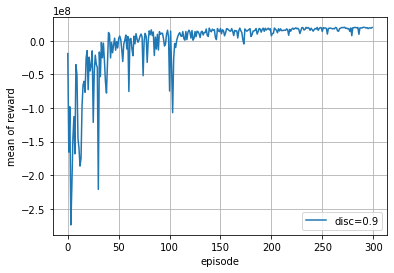

In [219]:
import matplotlib.pyplot as plt

def vis_stat(datas):
  epis = [[] for i in range(len(datas))]
  d = 0
  for data in datas:
    for i in data:
      # print(len(i['r']))
      epis[d].append(np.sum(np.array(i['r'])))
    d+=1

  avr_e = np.mean(np.array(epis), axis=0)

  return avr_e

dic09 = vis_stat(datas)

plt.plot(range(len(dic09)), dic09, label='disc=0.9')
plt.ylabel('mean of reward')
plt.xlabel('episode')
plt.legend()
plt.grid()
print('dist=0.9  : '+str(np.sum(np.array(dic09))/len(dic09)))

In [236]:
pipo = [22, 112, 122, 221, 212]
pipo = [211]

for i in range(5):
  for p in pipo:
    print(mapis[i*1000+p], pathes[-1][i*1000+p])

for i in range(14,20):
  for p in [311]:
    print(mapis[i*1000+p], pathes[-1][i*1000+p])

[0, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[1, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[2, 15, 10, 10] [0, 0, 1, 0, 0, 0, 0]
[3, 15, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[4, 15, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[14, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[15, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[16, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[17, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[18, 20, 10, 10] [0, 0, 0, 0, 0, 1, 0]
[19, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]


###other discount value

In [221]:
discs = [0, 0.1, 0.5, 1]
mris = [dic09]
pp = []

for i in discs:
  env.reset(4)
  agent = QLOffPolicyAgent('1'+str(i), env, 21000, disc=i)
  pathes, datas = run(agent)
  mris.append(vis_stat(datas))
  pp.append(pathes[-1])

inf
990000.0
999752.3901
994606.419519
986012.8670388159
931325.8117946491
977414.9310508448
925921.2459256535
940076.9838436932
770127.298112043
923656.3840682722
676903.6719975495
809750.8301799016
585150.4950901608
837708.5708555899
684208.6503874232
559458.7696299558
421515.3318434772
478226.1827863961
352976.5391126537
228372.42623970413
293649.44235548883
187256.44313884713
169403.5951817712
282879.2910388774
310980.2264661199
181578.50452860305
164501.66231902767
148930.84867814474
134752.76289033247
159084.05144754384
38152.04244769462
99513.94300147674
89873.9609609381
54852.12387859334
25031.555049932445
87113.90312304096
40140.02086418486
53751.11838070405
32576.68493093074
57825.55401553269
26428.6249491543
35489.238342029115
10775.263664305829
38230.31183246301
17379.74978812958
31052.381896285653
34851.97380625473
25208.86787134613
11420.041943566206
5153.77520732012
9255.280640077268
8331.688902048447
7500.088435886515
6751.350015772623
12117.55521908894
2738.92744995341

dist=0  : -3830001.0
dist=0.1  : -1689612.1111111117
dist=0.5  : -3902945.4444444464
dist=1  : -3104278.7777777785


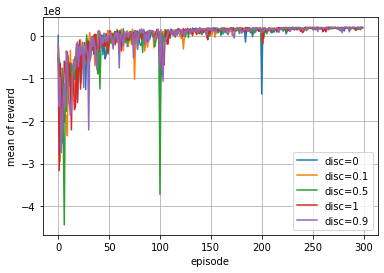

In [222]:
k = 0
for mr in mris[1:]:
  plt.plot(range(len(mr)), mr, label='disc='+str(discs[k]))
  print('dist='+str(discs[k])+'  : '+str(np.sum(np.array(mr))/len(mr)))
  k += 1
plt.plot(range(len(mris[0])), mris[0], label='disc=0.9')
plt.ylabel('mean of reward')
plt.xlabel('episode')
plt.legend()
plt.grid()

In [239]:
k = 0
for pa in pp:
  print(discs[k])
  for i in range(5):
    for p in pipo:
      print(mapis[i*1000+p], pa[i*1000+p])

  for i in range(14,20):
    for p in [311]:
      print(mapis[i*1000+p], pa[i*1000+p])
  k += 1

0
[0, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[1, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[2, 15, 10, 10] [0, 0, 0, 1, 0, 0, 0]
[3, 15, 10, 10] [0, 0, 0, 1, 0, 0, 0]
[4, 15, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[14, 20, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[15, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[16, 20, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[17, 20, 10, 10] [0, 0, 0, 1, 0, 0, 0]
[18, 20, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[19, 20, 10, 10] [0, 0, 0, 1, 0, 0, 0]
0.1
[0, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[1, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[2, 15, 10, 10] [0, 0, 0, 1, 0, 0, 0]
[3, 15, 10, 10] [0, 0, 0, 1, 0, 0, 0]
[4, 15, 10, 10] [0, 0, 1, 0, 0, 0, 0]
[14, 20, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[15, 20, 10, 10] [0, 1, 0, 0, 0, 0, 0]
[16, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[17, 20, 10, 10] [0, 0, 0, 0, 1, 0, 0]
[18, 20, 10, 10] [0, 0, 0, 0, 0, 0, 1]
[19, 20, 10, 10] [0, 0, 0, 0, 0, 0, 1]
0.5
[0, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[1, 15, 10, 10] [1, 0, 0, 0, 0, 0, 0]
[2, 15, 10, 10] [0, 0, 1, 0, 0, 0, 0]
[3, 15, 10, 10] [0, 0, 0, 1,